# Load data from Kaggle: the 30000 songs from Spotify
process the data first to see if any missing values and remove them. Remove unncessary features manually before classifying. Get number of genres and create genre labels for each class for testing and training purpose.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.init as init

%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv'
df_song = pd.read_csv(url)
df_song.head() # get an overview of how data looks

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [3]:
df_song.info() # display types and names of features in the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [4]:
# change date from string to a datetime object
df_song['track_album_release_date'] = pd.to_datetime(df_song['track_album_release_date'])

# Feature Selection and manipulate data so that it is ready for testing and training

In [5]:
# Check for duplication of data in rows if any
df_song.duplicated().sum()

0

In [6]:
# drop dubplication and only keep the first occurence
df_song = df_song.drop_duplicates()

In [7]:
# check completeness of data
df_song.isnull().sum()

track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

In [8]:
# check where the missing data locates
df_song.loc[df_song.track_name.isnull()]
# since other values are not null, we keep those rows in the data

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
8151,69gRFGOWY9OMpFJgFol1u0,NaN,NaN,0,717UG2du6utFe7CdmpuUe3,NaN,2012-01-05,HIP&HOP,5DyJsJZOpMJh34WvUrQzMV,rap,...,6,-7.635,1,0.1760,0.0410,0.00000,0.1160,0.649,95.999,282707
9282,5cjecvX0CmC9gK0Laf5EMQ,NaN,NaN,0,3luHJEPw434tvNbme3SP8M,NaN,2017-12-01,GANGSTA Rap,5GA8GDo7RQC3JEanT81B3g,rap,...,11,-5.364,0,0.3190,0.0534,0.00000,0.5530,0.191,146.153,202235
9283,5TTzhRSWQS4Yu8xTgAuq6D,NaN,NaN,0,3luHJEPw434tvNbme3SP8M,NaN,2017-12-01,GANGSTA Rap,5GA8GDo7RQC3JEanT81B3g,rap,...,10,-5.907,0,0.3070,0.0963,0.00000,0.0888,0.505,86.839,206465
19568,3VKFip3OdAvv4OfNTgFWeQ,NaN,NaN,0,717UG2du6utFe7CdmpuUe3,NaN,2012-01-05,Reggaeton viejito🔥,0si5tw70PIgPkY1Eva6V8f,latin,...,11,-6.075,0,0.0366,0.0606,0.00653,0.1030,0.726,97.017,252773
19811,69gRFGOWY9OMpFJgFol1u0,NaN,NaN,0,717UG2du6utFe7CdmpuUe3,NaN,2012-01-05,latin hip hop,3nH8aytdqNeRbcRCg3dw9q,latin,...,6,-7.635,1,0.1760,0.0410,0.00000,0.1160,0.649,95.999,282707


In [9]:
# Reduce non-important features in data manually by dropping the non-numeric columns and only keep numeric ones
df_song.drop(columns=['track_id','track_name','track_artist','track_album_id','track_album_name',
                         'playlist_id','playlist_name','playlist_id','playlist_subgenre', 'track_album_release_date'],inplace=True)

In [10]:
# check completeness of data
df_song.isnull().sum()

track_popularity    0
playlist_genre      0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
dtype: int64

In [11]:
# display the number of genres (labels in this task)
genre = df_song['playlist_genre'].unique()
genre

array(['pop', 'rap', 'rock', 'latin', 'r&b', 'edm'], dtype=object)

In [12]:
# convert the string value of genre into a binary variable
df_song['numeric_genre'] = df_song['playlist_genre'].map(
    {"pop": 1, "rap": 2, "rock":3, "latin":4, "r&b":5,  "edm":6})

In [13]:
df_song.info()
feature_list = ['track_popularity', 'danceability', 'energy', 'key', 'loudness',
                'mode', 'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32833 entries, 0 to 32832
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_popularity  32833 non-null  int64  
 1   playlist_genre    32833 non-null  object 
 2   danceability      32833 non-null  float64
 3   energy            32833 non-null  float64
 4   key               32833 non-null  int64  
 5   loudness          32833 non-null  float64
 6   mode              32833 non-null  int64  
 7   speechiness       32833 non-null  float64
 8   acousticness      32833 non-null  float64
 9   instrumentalness  32833 non-null  float64
 10  liveness          32833 non-null  float64
 11  valence           32833 non-null  float64
 12  tempo             32833 non-null  float64
 13  duration_ms       32833 non-null  int64  
 14  numeric_genre     32833 non-null  int64  
dtypes: float64(9), int64(5), object(1)
memory usage: 4.0+ MB


# Partition data into train and test splits so we can start training the model using k-fold validation

In [14]:
# display the shape of the data
df_song.shape

(32833, 15)

In [15]:
# Extract features and labels and create set to store them
X = df_song.drop(['playlist_genre', 'numeric_genre'], axis=1)  # feature set
y = df_song['numeric_genre'] # target variable

# Now data is ready to used for training and testing purpose. We also perform hyperparameter tuning and report test/train error and test accuracy. Plots are included.

# Try K-NN classifier with parameter tuning

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=7,
                                                    shuffle=True)

In [17]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (24624, 13)
Training Labels Shape: (24624,)
Testing Features Shape: (8209, 13)
Testing Labels Shape: (8209,)


In [18]:
from sklearn import metrics

# parameters
kvals = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

# test error list
knn_test_errors = []

for k in kvals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_accuracy = knn.score(X_test, y_test)
    knn_test_errors.append(1 - knn_accuracy)

    print(f'KNN with k={k} has test accuracy of {knn_accuracy:.8f}')

KNN with k=5 has test accuracy of 0.26483128
KNN with k=6 has test accuracy of 0.25849677
KNN with k=7 has test accuracy of 0.25191863
KNN with k=8 has test accuracy of 0.25033500
KNN with k=9 has test accuracy of 0.24862955
KNN with k=10 has test accuracy of 0.25118772
KNN with k=11 has test accuracy of 0.24643684
KNN with k=12 has test accuracy of 0.24339140
KNN with k=13 has test accuracy of 0.24607139
KNN with k=14 has test accuracy of 0.24899501
KNN with k=15 has test accuracy of 0.24777683
KNN with k=16 has test accuracy of 0.24765501


In [19]:
# best test accuracy
print(1-min(knn_test_errors))

0.2648312827384578


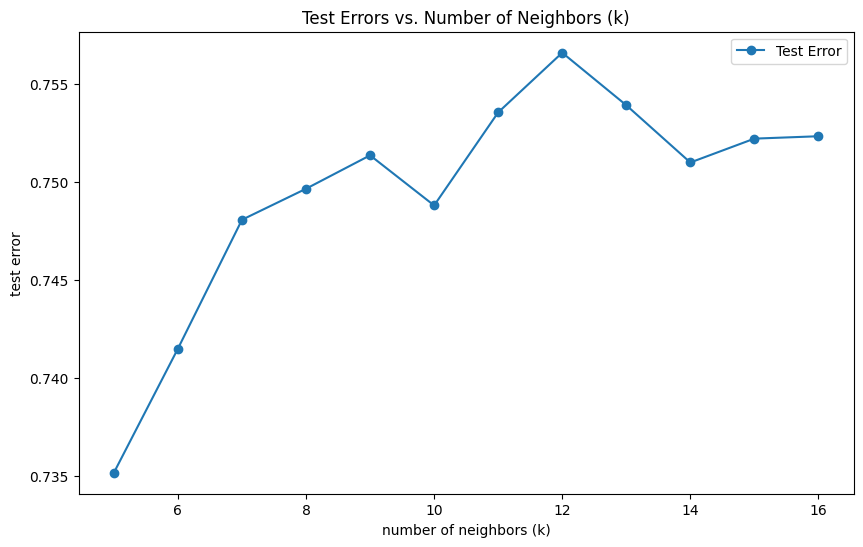

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(kvals, knn_test_errors, label='Test Error', marker='o')

plt.title('Test Errors vs. Number of Neighbors (k)')
plt.xlabel('number of neighbors (k)')
plt.ylabel('test error')
plt.legend()
plt.show()

Overall, this KNN classifier has bad accuracy performance and has high train and test error. Let's try another model.

# Logistic Regression
try logistic regression and logistic regression using SGD from sklearn

In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial', n_jobs = 5)
lr.fit(X_train, y_train)
lr_accuracy = lr.score(X_test, y_test)
# append the list of test error for the current alpha val
lr_accuracy

0.18443172128152027

In [22]:
lr_test_errors = []

learning_rates = [5.0, 4.75, 4.5, 4.0, 3.75, 3.5, 3.25, 3.0, 2.0]

for eta in learning_rates:
    # train and fit the model with logistic regression
    lr = SGDClassifier(loss='log_loss', penalty = 'l2', eta0 = eta)
    lr.fit(X_train, y_train)
    # predict on test data and get the test error (complement of accuracy)
    # against its true labels
    accuracy = lr.score(X_test, y_test)
    lr_test_errors.append(1-accuracy)
    print(f'lr={eta} has test accuracy of {accuracy:.12f}')

lr=5.0 has test accuracy of 0.162260933122
lr=4.75 has test accuracy of 0.154220976976
lr=4.5 has test accuracy of 0.184431721282
lr=4.0 has test accuracy of 0.154220976976
lr=3.75 has test accuracy of 0.168351808990
lr=3.5 has test accuracy of 0.184431721282
lr=3.25 has test accuracy of 0.162260933122
lr=3.0 has test accuracy of 0.167255451334
lr=2.0 has test accuracy of 0.184431721282


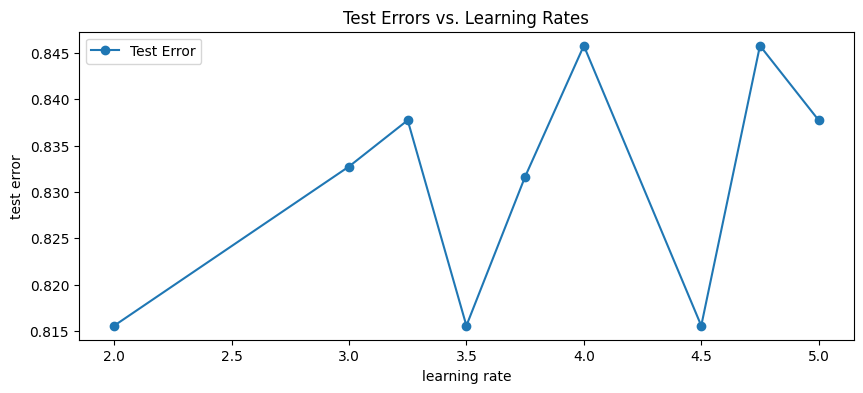

In [23]:
plt.figure(figsize=(10, 4))
plt.plot(learning_rates, lr_test_errors, label='Test Error', marker='o')

plt.title('Test Errors vs. Learning Rates')
plt.xlabel('learning rate')
plt.ylabel('test error')
plt.legend()
plt.show()

# Constrained Decision Tree and Random Forest

constrains on maximum depth, maximum leaf nodes and minimum samples on a leaf

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import export_graphviz
import pydot

clt_errors = []
nodes = [30, 50, 100, 200, 300, 350, 450, 500, 600, 700, None]
for d in nodes:
  clt = DecisionTreeClassifier(criterion="entropy", max_features=10, max_leaf_nodes=d)
  clt.fit(X_train, y_train)
  accuracy = clt.score(X_test, y_test)
  clt_errors.append(1-accuracy)
  print(f'max_leaf_nodes={d} has test accuracy of {accuracy:.12f}')

max_leaf_nodes=30 has test accuracy of 0.421732245097
max_leaf_nodes=50 has test accuracy of 0.456937507614
max_leaf_nodes=100 has test accuracy of 0.456572055062
max_leaf_nodes=200 has test accuracy of 0.477524668047
max_leaf_nodes=300 has test accuracy of 0.480813741016
max_leaf_nodes=350 has test accuracy of 0.475210135217
max_leaf_nodes=450 has test accuracy of 0.483859178950
max_leaf_nodes=500 has test accuracy of 0.482275551224
max_leaf_nodes=600 has test accuracy of 0.479473748325
max_leaf_nodes=700 has test accuracy of 0.483737361433
max_leaf_nodes=None has test accuracy of 0.439273967597


In [25]:
print(1-min(clt_errors))

0.483859178949933


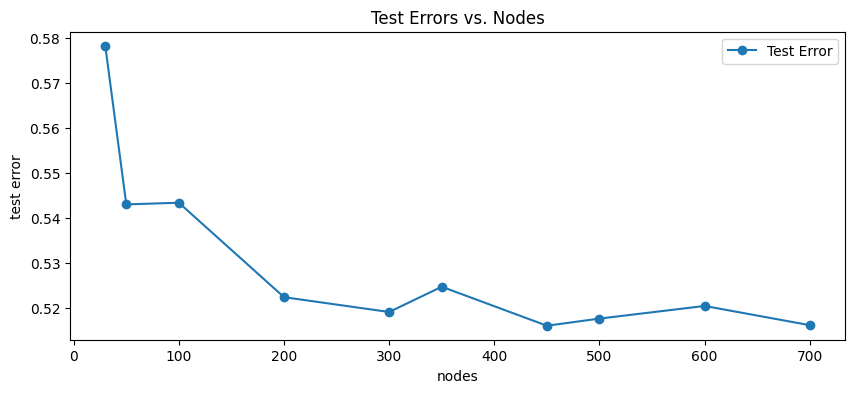

In [26]:
plt.figure(figsize=(10, 4))
plt.plot(nodes, clt_errors, label='Test Error', marker='o')

plt.title('Test Errors vs. Nodes')
plt.xlabel('nodes')
plt.ylabel('test error')
plt.legend()
plt.show()

In [27]:
clt = DecisionTreeClassifier(criterion="entropy", max_features=10, max_leaf_nodes=350)
clt.fit(X_train, y_train)
# Get numerical feature importances
importances = list(clt.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


Variable: tempo                Importance: 0.21
Variable: speechiness          Importance: 0.19
Variable: danceability         Importance: 0.15
Variable: energy               Importance: 0.11
Variable: valence              Importance: 0.08
Variable: instrumentalness     Importance: 0.07
Variable: duration_ms          Importance: 0.07
Variable: loudness             Importance: 0.06
Variable: acousticness         Importance: 0.05
Variable: track_popularity     Importance: 0.02
Variable: key                  Importance: 0.0
Variable: mode                 Importance: 0.0
Variable: liveness             Importance: 0.0


We can see that Decision tree performs better than logistic regression and knn classifier, we can proceed to use random forest - random ordering of feature selections. Let's also compare the feature importance from random forest.

In [28]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

depths = [5, 10, 20, 30]
rfc_errors = []
for d in depths:
  rfc = RandomForestClassifier(criterion="entropy", max_depth=500, max_features=d)
  rfc.fit(X_train, y_train)
  accuracy = rfc.score(X_test, y_test)
  rfc_errors.append(1-accuracy)
  print(f'max_depths={d} has test accuracy of {accuracy:.12f}')

max_depths=5 has test accuracy of 0.558776952126
max_depths=10 has test accuracy of 0.555731514192
max_depths=20 has test accuracy of 0.552076988671
max_depths=30 has test accuracy of 0.550371543428


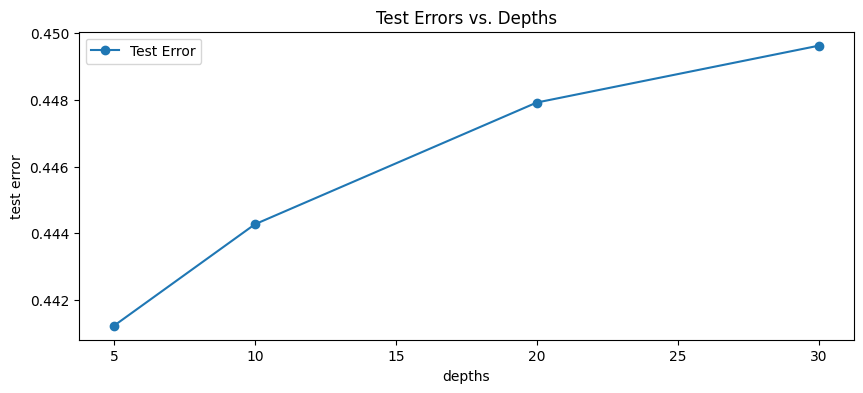

In [29]:
plt.figure(figsize=(10, 4))
plt.plot(depths, rfc_errors, label='Test Error', marker='o')

plt.title('Test Errors vs. Depths')
plt.xlabel('depths')
plt.ylabel('test error')
plt.legend()
plt.show()

In [30]:
rfc = RandomForestClassifier(criterion="entropy", max_depth=500, max_features=10)
rfc.fit(X_train, y_train)
# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


Variable: tempo                Importance: 0.13
Variable: speechiness          Importance: 0.12
Variable: danceability         Importance: 0.11
Variable: energy               Importance: 0.1
Variable: valence              Importance: 0.09
Variable: duration_ms          Importance: 0.08
Variable: loudness             Importance: 0.07
Variable: acousticness         Importance: 0.07
Variable: instrumentalness     Importance: 0.07
Variable: track_popularity     Importance: 0.06
Variable: liveness             Importance: 0.05
Variable: key                  Importance: 0.03
Variable: mode                 Importance: 0.01


Comparing the feature importance to that in the single decision tree, we can see that the top three features of most importance ar etempo. sppechiness, danceability. And the last three unimportant features are liveness, key, and mode. Feature selection may help improve test accuracy.

# Neural Network
We try to train some simple neural network model to see if there is more space for test accuracy increase

In [31]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# convert data to PyTorch tensors
X_train_tensor, X_test_tensor = torch.FloatTensor(X_train.values), torch.FloatTensor(X_test.values)
y_train_tensor, y_test_tensor = torch.LongTensor(y_train.values), torch.LongTensor(y_test.values)

In [32]:
train_data, test_data = TensorDataset(X_train_tensor, y_train_tensor), TensorDataset(X_test_tensor, y_test_tensor)

trainLoader = DataLoader(train_data, batch_size=64, shuffle=True)
testLoader = DataLoader(test_data, batch_size=64, shuffle=False)

In [33]:
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.init as init

class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.fc_model = torch.nn.Sequential(
            torch.nn.Linear(13, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(128),
            torch.nn.Linear(128, 10)
        )

  def forward(self, x):
    x = x.view(-1, 13)
    x = self.fc_model(x)
    return x

In [34]:
net = NeuralNetwork()
print(net)

NeuralNetwork(
  (fc_model): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [35]:
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

train_loss_history = []
test_accuracy_history = []
test_loss_history = []
num_epochs = 30

In [36]:
for epoch in range(num_epochs):
  train_loss = 0.0
  test_loss = 0.0
  net.train()
  for X_train, y_train in trainLoader:
     # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    predicted_output = net(X_train)
    fit = Loss(predicted_output, y_train)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()

  total, correct = 0, 0
  net.eval() # don't update weights
  for X_test, y_test in testLoader:
    with torch.no_grad():
        predicted_output = net(X_test)
        fit = Loss(predicted_output, y_test)

        _, predicted_labels = torch.max(predicted_output,1)
        total += y_test.size(0)
        correct += (predicted_labels == y_test).sum().item()
        test_accuracy = 100 * correct/total

        test_loss += fit.item()

  train_loss = train_loss/len(trainLoader)
  test_loss = test_loss/len(testLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  test_accuracy_history.append(test_accuracy)
  print('Epoch %s, Train loss %s, Test loss %s, test acc = %0.2f'%(epoch, train_loss, test_loss, test_accuracy))

Epoch 0, Train loss 1.9487049229733355, Test loss 2.017703095147776, test acc = 17.83
Epoch 1, Train loss 1.8420930261735793, Test loss 1.8141040358432503, test acc = 19.19
Epoch 2, Train loss 1.8149082502761444, Test loss 3.2655819183172183, test acc = 18.24
Epoch 3, Train loss 1.807336324221128, Test loss 1.7869743321293083, test acc = 21.67
Epoch 4, Train loss 1.7966716911885645, Test loss 1.8471206500548725, test acc = 18.33
Epoch 5, Train loss 1.7870179616011583, Test loss 1.7708451803340468, test acc = 23.27
Epoch 6, Train loss 1.7789611943356403, Test loss 1.826064942419067, test acc = 22.55
Epoch 7, Train loss 1.777713799786258, Test loss 1.7955759024435236, test acc = 22.60
Epoch 8, Train loss 1.773040949524223, Test loss 1.7639408915541892, test acc = 22.85
Epoch 9, Train loss 1.770403190711876, Test loss 1.7817167126855185, test acc = 20.17
Epoch 10, Train loss 1.7712673239893728, Test loss 1.7647738290387531, test acc = 23.24
Epoch 11, Train loss 1.7665497854158476, Test lo

In [37]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)

train_loss_history = []
test_accuracy_history = []
test_loss_history = []
num_epochs = 30

In [38]:
for epoch in range(num_epochs):
  train_loss = 0.0
  test_loss = 0.0
  net.train()
  for X_train, y_train in trainLoader:
     # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    predicted_output = net(X_train)
    fit = Loss(predicted_output, y_train)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()

  total, correct = 0, 0
  net.eval() # don't update weights
  for X_test, y_test in testLoader:
    with torch.no_grad():
        predicted_output = net(X_test)
        fit = Loss(predicted_output, y_test)

        _, predicted_labels = torch.max(predicted_output,1)
        total += y_test.size(0)
        correct += (predicted_labels == y_test).sum().item()
        test_accuracy = 100 * correct/total

        test_loss += fit.item()

  train_loss = train_loss/len(trainLoader)
  test_loss = test_loss/len(testLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  test_accuracy_history.append(test_accuracy)
  print('Epoch %s, Train loss %s, Test loss %s, test acc = %0.2f'%(epoch, train_loss, test_loss, test_accuracy))

Epoch 0, Train loss 1.7784377760701364, Test loss 1.7833997112836024, test acc = 20.05
Epoch 1, Train loss 1.760581763069351, Test loss 1.7586480499238006, test acc = 19.97
Epoch 2, Train loss 1.7579025624634383, Test loss 1.7573427959930066, test acc = 21.76
Epoch 3, Train loss 1.7576584320563775, Test loss 1.754354945448942, test acc = 23.35
Epoch 4, Train loss 1.753525863065348, Test loss 1.7566968803257905, test acc = 21.61
Epoch 5, Train loss 1.753881058754859, Test loss 1.7539482874463694, test acc = 22.99
Epoch 6, Train loss 1.7533110572146131, Test loss 1.7536378470502159, test acc = 22.72
Epoch 7, Train loss 1.7523378121388422, Test loss 1.7556279814520548, test acc = 23.33
Epoch 8, Train loss 1.7549131963160132, Test loss 1.748190588729326, test acc = 24.01
Epoch 9, Train loss 1.7504841662072517, Test loss 1.7544805273529172, test acc = 23.04
Epoch 10, Train loss 1.7490533014396568, Test loss 1.749578174694564, test acc = 23.61
Epoch 11, Train loss 1.7522648021772311, Test lo

It seems like it is hard to run 30 epochs. Therefore, we tried to implement a fully connected neural network.

In [42]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Define a fully connected network
class NeuralNetwork(nn.Module):
  def __init__(self, input_size):
    super(NeuralNetwork, self).__init__()
    self.fc1 = nn.Linear(input_size, 128)
    self.fc2 = nn.Linear(128, 64)
    # Output for 6 classes
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# Function to train the model
def train(model, train_loader, val_loader, epochs=10):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []

  for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for data in train_loader:
      inputs, labels = data
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
      for data in val_loader:
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train loss: {train_losses[-1]:.4f},"
          f"Train accuracy: {train_accuracies[-1]:.2f}%, "
          f"Val loss: {val_losses[-1]:.4f}, "
          f"Val accuracy: {val_accuracies[-1]:.2f}%")

  return train_losses, val_losses, train_accuracies, val_accuracies

In [43]:
from sklearn.preprocessing import StandardScaler

# Split the data into training and teststing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=7,
                                                    shuffle=True)
s = StandardScaler()
s.fit(X_train)
x_train_scale = s.transform(X_train)
x_test_scale = s.transform(X_test)


# Convert the numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train_scale, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_scale, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Update the DataLoader with the new data
train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=64)
input_size = x_train_scale.shape[1]

# Reinitialize the model and retrain
model = NeuralNetwork(input_size)
epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, epochs)

Epoch 1/20 - Train loss: 1.4399,Train accuracy: 44.94%, Val loss: 1.3238, Val accuracy: 48.43%
Epoch 2/20 - Train loss: 1.2997,Train accuracy: 50.06%, Val loss: 1.2834, Val accuracy: 49.92%
Epoch 3/20 - Train loss: 1.2663,Train accuracy: 51.30%, Val loss: 1.2533, Val accuracy: 52.08%
Epoch 4/20 - Train loss: 1.2451,Train accuracy: 52.54%, Val loss: 1.2492, Val accuracy: 51.52%
Epoch 5/20 - Train loss: 1.2310,Train accuracy: 52.55%, Val loss: 1.2355, Val accuracy: 52.49%
Epoch 6/20 - Train loss: 1.2170,Train accuracy: 53.57%, Val loss: 1.2271, Val accuracy: 52.89%
Epoch 7/20 - Train loss: 1.2064,Train accuracy: 53.83%, Val loss: 1.2272, Val accuracy: 53.05%
Epoch 8/20 - Train loss: 1.1964,Train accuracy: 54.46%, Val loss: 1.2165, Val accuracy: 53.38%
Epoch 9/20 - Train loss: 1.1870,Train accuracy: 54.85%, Val loss: 1.2116, Val accuracy: 53.88%
Epoch 10/20 - Train loss: 1.1778,Train accuracy: 55.20%, Val loss: 1.2136, Val accuracy: 53.75%
Epoch 11/20 - Train loss: 1.1703,Train accuracy: 

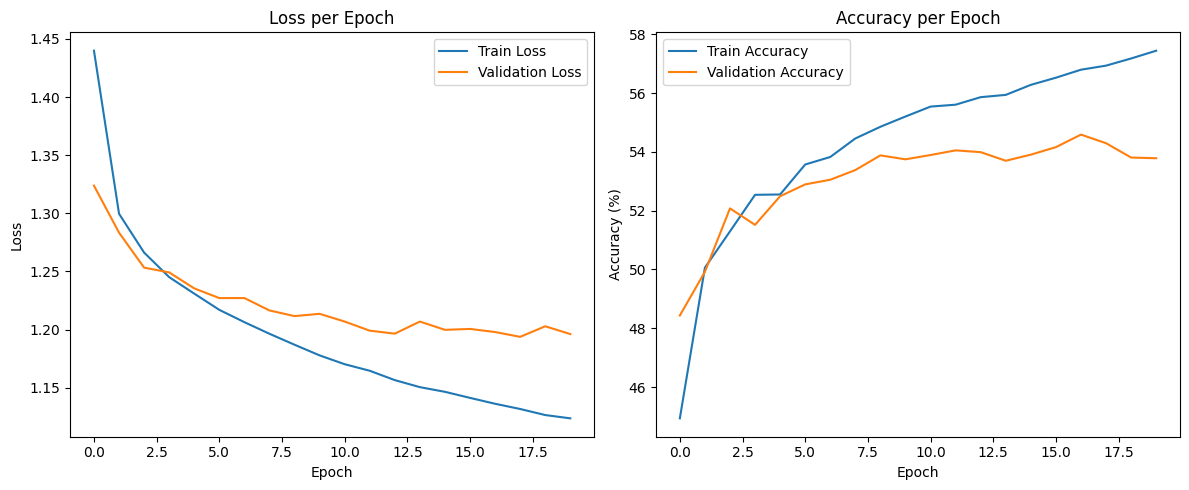

In [44]:
# Plotting the updated loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()